<a href="https://colab.research.google.com/github/cruzguo/Visionary-QA-Engine/blob/main/Copy_of_screaming_firehawk_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
# hacklytics2024 submission by Sri, Cruz, Atharva and Vriksha
import os
import re
import nltk
import json
import gdown
import torch
import torchvision
import unicodedata

import numpy as np
import pandas as pd
import torch.nn as nn
import tensorflow as tf
import torch.nn.functional as Functional

from PIL import Image
from torch import optim
from nltk import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as F



# ignore all warnings
import warnings
warnings.filterwarnings('ignore')

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class VOCAB:
  def __init__(self):
    self.PAD = "PAD"
    self.UNK = "UNK"
    self._word2index = {"PAD": 0, "UNK": 1}  # Map word to token index
    self._index2word = {0: "PAD", 1: "UNK"}  # Map token index to word
    # Number of unique words in the corpus
    self._n_words = 2  # Count PAD and UNK
    self.word_count = {}


  def keep_top_thousand(self):
    sorted_word_count = sorted(self.word_count.items(), key=lambda x: x[1], reverse=True)
    # Take the top 1000 words
    top_1000_words = sorted_word_count[:4998]

    # Create new dictionaries for top 1000 words
    word2index = {"PAD": 0, "UNK": 1}  # Initialize with PAD and UNK
    index2word = {0: "PAD", 1: "UNK"}

    # Assign indices to the top 1000 words
    index = 2  # Start index from 2 (0 and 1 are already assigned to PAD and UNK)
    for word, count in top_1000_words:
      word2index[word] = index
      index2word[index] = word
      index += 1

    self._word2index = word2index
    self._index2word = index2word
    self._n_words = len(word2index.keys())

  # Get a list of all words in corpus
  def get_words(self):
    return list(self._word2index.keys())

  # Get the number of words
  def num_words(self):
    return self._n_words

  # Convert a word into a token index
  def word2index(self, word):
    if word not in self._word2index:
      return self._word2index[self.UNK]
    else:
      return self._word2index[word]

  # Convert a token into a word
  def index2word(self, token):
    if token not in self._index2word:
      return self._index2word[self._word2index[self.UNK]]
    else:
      return self._index2word[token]

  # Add all the words in a sentence to the vocabulary
  def add_normalized_sentence(self, sentence):
    for word in sentence.split(' '):
      self.add_word(word)

  # Add a single word to the vocabulary
  def add_word(self, word):
    if word not in self._word2index:
      self._word2index[word] = self._n_words
      self._index2word[self._n_words] = word
      self.word_count[word] = 1
      self._n_words += 1
    else:
      # Increment the word count if the word already exists
      self.word_count[word] += 1

  @staticmethod
  def unicode_to_ascii(s):
    return ''.join(
      c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn'
    )

  @staticmethod
  def normalize_string(s):
    s = VOCAB.unicode_to_ascii(s.lower().strip())
    s = s.replace('\n', ' ').replace('\t', '')
    s = re.sub(r'[^\w\s.]', '', s)
    return s

  def add_book_from_txt_file(self, filename):
    with open(filename, encoding='utf-8') as f:
      text = f.read()
    # Convert any unicode to ascii, and normalize the string
    normalized_text = VOCAB.normalize_string(text)
    self.add_normalized_sentence(normalized_text)

  def add_raw_sentence(self, s):
    normalized_text = VOCAB.normalize_string(s)
    self.add_normalized_sentence(normalized_text)

In [ ]:
question_vocabulary = VOCAB()
answer_vocabulary = VOCAB()
print("Created question and answer vocabulary")
gdown.download('https://drive.google.com/uc?id=1FAWTTsqctyk07fBC9QUpGHpSW_lmOPvW', 'annotations.json', quiet=False)
gdown.download('https://drive.google.com/uc?id=1XsTVH__eePFO8lLWkjbledc0sKAdgtB7', 'questions.json', quiet=False)

Created question and answer vocabulary


Downloading...
From (original): https://drive.google.com/uc?id=1FAWTTsqctyk07fBC9QUpGHpSW_lmOPvW
From (redirected): https://drive.google.com/uc?id=1FAWTTsqctyk07fBC9QUpGHpSW_lmOPvW&confirm=t&uuid=4fcc7fce-10f5-46d0-83b9-36dfed075df0
To: /content/annotations.json
100%|██████████| 356M/356M [00:06<00:00, 56.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1XsTVH__eePFO8lLWkjbledc0sKAdgtB7
To: /content/questions.json
100%|██████████| 42.0M/42.0M [00:00<00:00, 45.0MB/s]


'questions.json'

In [ ]:
def extract_words_from_json():
  questions_filename = 'questions.json'
  answers_filename = 'annotations.json'
  with open(questions_filename, 'r') as file:
    json_data = json.load(file)
    for question_obj in json_data['questions']:
      question_text = question_obj['question']
      question_vocabulary.add_raw_sentence(question_text)

  with open(answers_filename, 'r') as file:
    data = json.load(file)
    for annotation_obj in data['annotations']:
      answer_text = annotation_obj['multiple_choice_answer']
      answer_vocabulary.add_raw_sentence(answer_text)

extract_words_from_json()
print("Updated vocabulary with words from questions and annotations")
print("Question Vocabulary has", question_vocabulary.num_words(), "words")
print("Answer Vocabulary has", answer_vocabulary.num_words(), "words")
answer_vocabulary.keep_top_thousand()
print("Answer Vocabulary has", answer_vocabulary.num_words(), "words")

Updated vocabulary with words from questions and annotations
Question Vocabulary has 13814 words
Answer Vocabulary has 13374 words
Answer Vocabulary has 5000 words


In [ ]:
class SelfAttention(nn.Module):  # This class is the self attention layer
	def __init__(self, embedding_dimension, head_dimension):
		super().__init__()
		self.embedding_dimension = embedding_dimension
		self.head_dimension = head_dimension
		self.q = nn.Linear(self.embedding_dimension, self.head_dimension)
		self.k = nn.Linear(self.embedding_dimension, self.head_dimension)
		self.v = nn.Linear(self.embedding_dimension, self.head_dimension)

		self.softmax = nn.Softmax(dim=-1)

	def forward(self, x, mask):
		"""
	    Input is of shape [batch size, sequence_length, EMBEDDING_DIMENSION]
	    mask is to help us ignore the pad tokens and to white-out anything we haven't seen yet.

	    mask is of shape batch_size, sequence length
	    """
		query = self.q(x)
		key = self.k(x)
		value = self.v(x)

		attention_weights = torch.matmul(query, key.transpose(-2, -1))  # =QK.T
		attention_weights = attention_weights / np.sqrt(self.head_dimension)  # =(QK.T)/√head_dim

		# Apply the mask to the attention weights, by setting the masked tokens to a very low value.
		# This will make the softmax output 0 for these values.
		mask = mask.reshape(attention_weights.shape[0], 1, attention_weights.shape[2])
		attention_weights = attention_weights.masked_fill(mask == 2, 1e-9)  # 2 is pad for us

		# Softmax makes sure all scores are between 0 and 1 and the sum of scores is 1.
		# attention_scores dimensions are: (batch_size, sequence_length, sequence_length)
		attention_scores = self.softmax(attention_weights)

		# Output dimensions are: (batch_size, sequence_length, head_dimension)
		return torch.bmm(attention_scores, value)  # =((QK.T)/√head_dim)*V


In [ ]:
class MultiHeadedSelfAttention(nn.Module):
	def __init__(self, embedding_dimension, number_of_heads):
		super().__init__()
		self.embedding_dimension = embedding_dimension
		self.head_dimension = embedding_dimension // number_of_heads
		self.number_of_heads = number_of_heads
		self.multi_heads = nn.ModuleList([SelfAttention(embedding_dimension, self.head_dimension) for _ in range(number_of_heads)])

		# Create a linear layer to combine the outputs of the self attention modules
		self.output_layer = nn.Linear(number_of_heads * self.head_dimension, embedding_dimension)

	def forward(self, x, mask):
		self_attention_outputs = []
		for head in self.multi_heads:
			output = head(x, mask)
			self_attention_outputs.append(output)
		concatenated_self_attention_outputs = torch.cat(self_attention_outputs, dim=2)
		return self.output_layer(concatenated_self_attention_outputs)


In [ ]:
class FeedForward(nn.Module):
	def __init__(self, embedding_dimension, feed_forward_dimension):
		super().__init__()
		self.embedding_dimension = embedding_dimension
		self.feed_forward_dimension = feed_forward_dimension
		self.linear_1 = nn.Linear(embedding_dimension, feed_forward_dimension)
		self.linear_2 = nn.Linear(feed_forward_dimension, embedding_dimension)

	def forward(self, x):
		# simple forward pass through linear_layer
		linear_1_out = self.linear_1(x)
		activated = torch.relu(linear_1_out)
		return self.linear_2(activated)

In [ ]:
class Encoder(nn.Module):
	def __init__(self, embedding_dimension, number_of_heads, feed_forward_dimension, dropout_rate):
		super().__init__()
		self.embedding_dimension = embedding_dimension
		self.num_heads = number_of_heads
		self.feed_forward_dimension = feed_forward_dimension
		self.dropout_rate = dropout_rate

		self.multi_headed_attention = MultiHeadedSelfAttention(
			self.embedding_dimension,
			self.num_heads
		)

		self.dropout_layer = nn.Dropout(p=self.dropout_rate)
		self.feed_forward = FeedForward(embedding_dimension, feed_forward_dimension)
		self.layer_normalization_1 = nn.LayerNorm(embedding_dimension)
		self.layer_normalization_2 = nn.LayerNorm(embedding_dimension)

	def forward(self, x, mask):
		# use the attention layer
		attention_out = self.multi_headed_attention(x, mask)
		# add residual # from ResNet
		attention_output_and_residual = x + attention_out
		# normalize the attention_output_and_residual
		normalized_residual = self.layer_normalization_1(attention_output_and_residual)
		# feed forward
		ff_output = self.feed_forward(normalized_residual)
		# add residual to ff_out
		ff_output_and_residual = normalized_residual + ff_output
		# normalize again
		re_normalized = self.layer_normalization_2(ff_output_and_residual)
		# Dropout, only when training.
		if self.training:
			re_normalized = self.dropout_layer(re_normalized)

		# Residual output
		return re_normalized

In [ ]:
class EncoderStack(nn.Module):
	def __init__(
			self,
			embedding_dimension,
			number_of_layers,
			number_of_heads,
			feed_forward_dimension,
			dropout_rate,
			max_sequence_length
	):
		super().__init__()
		self.embedding_dimension = embedding_dimension
		self.number_of_layers = number_of_layers
		self.number_of_heads = number_of_heads
		self.feed_forward_dimension = feed_forward_dimension
		self.dropout_rate = dropout_rate
		self.max_sequence_length = max_sequence_length

		# Create the encoder layers
		self.encoder_layers = nn.ModuleList([
			Encoder(
				embedding_dimension,
				number_of_heads,
				feed_forward_dimension,
				dropout_rate
			)
			for _ in range(number_of_layers)
		])

	def forward(self, x, mask):
		encoder_out = x
		for encoder_layer in self.encoder_layers:
			encoder_out = encoder_layer(encoder_out, mask)

		return encoder_out

In [ ]:
class LMHead(nn.Module):
	"""
  a linear layer that maps the embedding dimension to the vocabulary size.
  """

	def __init__(self, embedding_dimension, number_of_out_tokens):
		super().__init__()
		self.embedding_dimension = embedding_dimension
		self.number_of_tokens = number_of_out_tokens
		self.linear = nn.Linear(embedding_dimension, number_of_out_tokens)

	def forward(self, x):
		last_position_output = x[:, -1, :]
		linear_output = self.linear(last_position_output)
		return linear_output

In [ ]:
def positional_encoder(embedding_dimensions, sequence_length):
	"""
	Needs to be called only once. These are fixed. Store once and reuse
	:param embedding_dimensions: The number of tokens in our vocabulary
	:param sequence_length: The length of context history we consider.
	:return: A tensor of shape [seq_len, embedding_dimensions]
	"""
	DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
	# Like the paper, I will use fixed embeddings, and generate them at run time
	positional_encoding = torch.zeros(sequence_length, embedding_dimensions)
	# position is an array going from 0-seq_len, but reshaped, so it's a 2d matrix [seq_len, 1]
	position = torch.arange(0, sequence_length, dtype=torch.int).unsqueeze(1)
	# for every dimension_index, multiply by 2, divide by embedding_dimensions, and use that as exponent
	# just read the paper again

	div_term = 10000 ** (2 * torch.arange(embedding_dimensions // 2) / (embedding_dimensions // 2))

	# even numbered columns are sine
	positional_encoding[:, 0::2] = torch.sin(position * div_term)
	# odd numbered columns are cosine
	positional_encoding[:, 1::2] = torch.cos(position * div_term)

	positional_encoding = positional_encoding.to(dtype=torch.long, device=DEVICE)
	return positional_encoding

In [ ]:
class Transformer(nn.Module):
  def __init__(
      self,
      number_of_in_tokens,  # The number of tokens in the question_vocabulary
      number_of_out_tokens,  # The number of tokens in the answer_vocabulary
      max_sequence_length=16,  # The context window
      embedding_dimension=512,  # The dimension of the token embeddings
      number_of_layers=4,  # The number of encoder layers to use
      number_of_heads=2,  # The number of attention heads to use
      feed_forward_dimension=1024,  # The dimension of the feed forward layer
      dropout_rate=0.1  # The dropout rate to use
  ):
    super().__init__()
    self.number_of_in_tokens = number_of_in_tokens
    self.number_of_out_tokens = number_of_out_tokens
    self.max_sequence_length = max_sequence_length
    self.embedding_dimension = embedding_dimension
    self.number_of_layers = number_of_layers
    self.number_of_heads = number_of_heads

    if feed_forward_dimension is None:
      self.feed_forward_dimension = 1000
    else:
      self.feed_forward_dimension = feed_forward_dimension

    self.dropout_rate = dropout_rate

    # Create the token embedding layer
    self.token_embedding = nn.Embedding(
      num_embeddings=number_of_in_tokens,
      embedding_dim=embedding_dimension
    )

    # Create the normalization layer
    self.layer_normalization = nn.LayerNorm(embedding_dimension)

    # Create the encoder stack
    self.encoder = EncoderStack(
      embedding_dimension=embedding_dimension,
      number_of_layers=number_of_layers,
      number_of_heads=number_of_heads,
      feed_forward_dimension=self.feed_forward_dimension,
      dropout_rate=dropout_rate,
      max_sequence_length=max_sequence_length
    )

    # Create the language model head
    self.lm_head = LMHead(embedding_dimension, number_of_out_tokens)
    self.positional_encoding = positional_encoder(
      self.embedding_dimension,
      sequence_length=max_sequence_length
    )

  def forward(self, x, mask):
    # token_embeddings dimensions are: (batch_size, sequence_length, EMBEDDING_DIMENSION)
    token_embeddings = self.token_embedding(x)
    # positional_encoding dimensions are: (batch_size, sequence_length, EMBEDDING_DIMENSION)
    position_encoded_tokens = self.positional_encoding[:token_embeddings.size(1), :] + token_embeddings
    # Post embedding layer normalization
    positional_encoding_normalized = self.layer_normalization(position_encoded_tokens)
    encoder_outputs = self.encoder(positional_encoding_normalized, mask)
    lm_head_outputs = self.lm_head(encoder_outputs)
    return lm_head_outputs


In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.model_conv = torchvision.models.resnext101_64x4d(pretrained=True)
    for param in self.model_conv.parameters():
      param.requires_grad = False

  def forward(self, x):
    return self.model_conv(x)


In [ ]:
class CNN_Wrapper(nn.Module):
  def __init__(self, cnn):
    super().__init__()
    self.model_conv = cnn
    self.fc1 = nn.Linear(1000, 5000) # first 1000 is resnet out, 13374 is just a number we choose

  def forward(self, x):
      x = self.model_conv(x)
      x = self.fc1(x)
      return x

In [ ]:
class VQA(nn.Module):
  def __init__(self, transformer, cnn):
    super().__init__()
    self.transformer = transformer
    self.cnn_wrapper = CNN_Wrapper(cnn)

    self.fc1 = nn.Linear(5000, 5000)  # First 13374 is just cnn/transformer out shape, Second 13374 is determined by the vocabulary output
    self.relu = nn.ReLU()

  def forward(self, x, mask, image):
    cnn_out = self.cnn_wrapper(image)
    transformer_out = self.transformer(x, mask)

    # elementwise product
    combined = cnn_out * transformer_out
    out = self.relu(combined)
    out = self.fc1(out)

    return out

In [ ]:
# Hyperparameters
QUESTION_VOCAB_SIZE = question_vocabulary.num_words()
ANSWER_VOCAB_SIZE = answer_vocabulary.num_words()
EMBEDDING_DIMENSION = 512
CONTEXT_WINDOW = 16
NUM_ENCODER_LAYERS = 6
NUM_ATTENTION_HEADS = 2
DROPOUT_RATE = 0.01
EPOCHS = 12
BATCH_SIZE = 512

In [ ]:
# Initialize the VQA
transformer = Transformer(
  number_of_in_tokens=QUESTION_VOCAB_SIZE,
  number_of_out_tokens=ANSWER_VOCAB_SIZE,
  max_sequence_length=CONTEXT_WINDOW,
  embedding_dimension=EMBEDDING_DIMENSION,
  number_of_layers=NUM_ENCODER_LAYERS,
  number_of_heads=NUM_ATTENTION_HEADS,
  dropout_rate=DROPOUT_RATE
)
cnn = CNN()

transformer.to(DEVICE)
cnn.to(DEVICE)

screaming_firehawk = VQA(transformer, cnn)
screaming_firehawk.to(DEVICE)

Downloading: "https://download.pytorch.org/models/resnext101_64x4d-173b62eb.pth" to /root/.cache/torch/hub/checkpoints/resnext101_64x4d-173b62eb.pth
100%|██████████| 319M/319M [00:02<00:00, 125MB/s]


VQA(
  (transformer): Transformer(
    (token_embedding): Embedding(13814, 512)
    (layer_normalization): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (encoder): EncoderStack(
      (encoder_layers): ModuleList(
        (0-5): 6 x Encoder(
          (multi_headed_attention): MultiHeadedSelfAttention(
            (multi_heads): ModuleList(
              (0-1): 2 x SelfAttention(
                (q): Linear(in_features=512, out_features=256, bias=True)
                (k): Linear(in_features=512, out_features=256, bias=True)
                (v): Linear(in_features=512, out_features=256, bias=True)
                (softmax): Softmax(dim=-1)
              )
            )
            (output_layer): Linear(in_features=512, out_features=512, bias=True)
          )
          (dropout_layer): Dropout(p=0.01, inplace=False)
          (feed_forward): FeedForward(
            (linear_1): Linear(in_features=512, out_features=1024, bias=True)
            (linear_2): Linear(in_features

# Test the model architecture and proceed to demo

In [ ]:
image_input = torch.randn(1, 3, 224, 224)  # Example: 1 image with 3 channels, 224x224 size
# Assuming the question input is represented as a sequence of tokens
x = torch.randint(0, QUESTION_VOCAB_SIZE, (1, 16))  # Example: 1 question with 10 tokens
mask = torch.randint(0, QUESTION_VOCAB_SIZE, (1, 16))

screaming_firehawk.to(DEVICE)
x = x.to(DEVICE)
mask = mask.to(DEVICE)
image_input = image_input.to(DEVICE)

# Forward pass through the model
out = screaming_firehawk(x, mask, image_input)
print(out.size())

torch.Size([1, 5000])


In [ ]:
# upload model before running
screaming_firehawk = torch.load('vqa.pt')

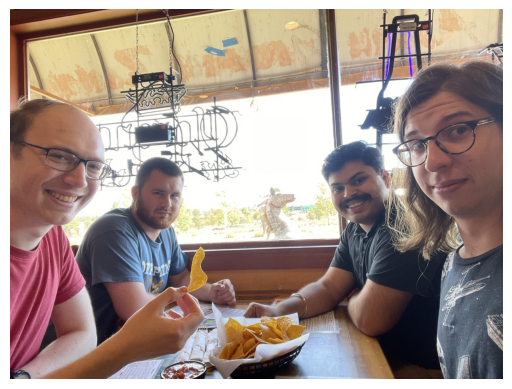

In [ ]:
import matplotlib.pyplot as plt

# image = Image.open('atharva.jpeg') # q: Is he wearing glasses?
# image = Image.open('people1.jpeg') # q: What is the color of the shirt?
# image = Image.open('vehicle.jpeg') # q: Is it daytime? / Is there a plane?
# image = Image.open('winter.jpeg') # q: Is it snowing? / what is the color of the building
# image = Image.open('people2.jpeg') # q: How many people are there?
# image = Image.open('breakfast.jpeg') # q: Is there coffee in this image?
image = Image.open('nachos.jpeg') # q: What are they eating?
# image = Image.open('sri.jpeg') # q: Does he have a moustache?

plt.imshow(image)
plt.axis('off')  # Hide axis
plt.show()

In [ ]:
query = input('Enter your question: ')
resized_img = np.array(image.resize((224, 224)))
reshaped_img = np.transpose(resized_img, (2,0,1))

user_input = query.split()
if len(user_input) > CONTEXT_WINDOW:
    user_input = user_input[-CONTEXT_WINDOW:]

padding_length = CONTEXT_WINDOW - len(user_input)
if padding_length > 0:
    padding = np.array([question_vocabulary.PAD] * padding_length)
    user_input = np.concatenate((padding, user_input))

encoded_question = torch.tensor([np.array([question_vocabulary.word2index(word) for word in user_input])], device=DEVICE)
mask_tensor = torch.ones_like(encoded_question, dtype=torch.long, device=DEVICE)
mask_tensor[encoded_question == question_vocabulary.word2index("PAD")] = 0
# print(encoded_question)
transform = transforms.ToTensor()
tensor_img = transform(resized_img)
tensor_img = tensor_img.float()
tensor_img = torch.unsqueeze(tensor_img, 0)
tensor_img = tensor_img.to(DEVICE)

Enter your question: What are they doing?


In [ ]:
SOFTMAX = nn.Softmax(dim=-1)

In [ ]:
with (torch.no_grad()):
  screaming_firehawk.eval()
  prediction = screaming_firehawk(encoded_question, mask_tensor, tensor_img)
  prediction /= 0.6 # temperature
  prediction = SOFTMAX(prediction)

  sorted_probs, sorted_indices = torch.sort(prediction, descending=True, dim=1)
  # print(sorted_probs[:5])
  n = 5 # change n  to control number of outputs
  top_n_indices = sorted_indices[:, :n]
  top_n_words = [answer_vocabulary.index2word(idx.item()) for idx in top_n_indices[0]]

  print(f"Top {n} most likely outputs:", top_n_words)


Top 5 most likely outputs: ['decor', '18', 'frisbee', 'bad', 'sitting']


In [ ]:
with (torch.no_grad()):
    screaming_firehawk.eval()
    prediction = screaming_firehawk(encoded_question, mask_tensor, tensor_img)
    prediction /= 0.9 # temperature
    prediction = SOFTMAX(prediction)

    max_index, min_index = torch.argmax(prediction, dim=1).item(), torch.argmin(prediction, dim=1).item()

    max_prob_word, min_prob_word = answer_vocabulary.index2word(max_index), answer_vocabulary.index2word(min_index)

    print("Most likely output:", max_prob_word)
    # print("Least likely output:", min_prob_word)

Most likely output: 3


In [ ]:
# able to answer in the same theme (color/count/boolean etc), but frequently (not always!) same output vector.
# I suspect the nlp model has more importance than resnext